<a href="https://colab.research.google.com/github/lucas-pinto/NUIN443/blob/main/problemSets/ps12_RNN_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.signal import correlate
%matplotlib widget
%matplotlib widget


## Problem Set 12: Computing with Recurrent Neural Networks
Our goal today is to simulate a firing rate recurrent neural network, and develop an intuition for how it behaves.

Let's start by implementing a standard RNN of $N$ neurons with a hyperbolic tangent nonlinearity. Written in matrix notation, the dynamics of this system are defined by the equation:

\begin{equation}
\tau \frac{dx}{dt} = -x + J\phi(x) + J^{in}u\\
\end{equation}

where $\phi(x) = \tanh(x)$ is our firing rate nonlinearity, $J$ is our $N\times N$ recurrent weight matrix where $J_{ij} \sim \mathcal{N}(0,\frac{g}{\sqrt{N}})$, $\tau$ is the membrane time constant, $u$ is time-varying external input, and $J^{in}$ is a set of weights by which that input drives our neurons, where we will take $J^{in}_{ij} \sim \mathcal{N}(0,w)$.

### Problem 1. Simluating a random RNN.
First, let's simulate a randomly connected RNN and see how it responds to a driving input.

<font color=violet>1a. Complete the code snippet below to simulate the dynamics of a randomly connected RNN with recurrent weight matrix $J$ and input weights $J^{in}$ defined as above, and network parameters defined by the entries of the params struct.</font>

In [2]:
params = {'N': 1000,      # number of neurons in the network
          'tau': 10,      # "membrane" time constant
          'dt': 1,        # simulation timestep
          'g': 2,         # gain on recurrent weights
          'n_inputs': 2,  # number of input channels
          'w': 0.1}       # variance of input weights

In [3]:
def simulate_RNN(params, u = np.zeros(1), T=5000, J = np.zeros(1)):

    N = params['N']
    w = params['w']
    tau = params['tau']
    dt = params['dt']
    g = params['g']
    n_inputs = params['n_inputs']

    if not J.any():
        covs = np.identity(N) * (g/np.sqrt(N))
        means =  np.zeros(N)
        J = np.random.multivariate_normal(mean=means, cov=covs, size=N)
        
    means = np.zeros(n_inputs)
    covs = np.identity(n_inputs) * w
    W = np.random.multivariate_normal(mean=means, cov=covs, size=N)

    if not u.any():
        u = np.zeros((n_inputs,T))
    else:
        T = u.shape[1]

    x = np.random.rand(N)
    rstore = np.zeros((T,N))

    for t in range(1,T):
        neuron_input = J@np.tanh(x)
        ext_input = W@np.expand_dims(u[:,t-1], 1)
        dxdt = -x + np.squeeze(neuron_input) + np.squeeze(ext_input)
        temp = x+dxdt/tau
        rstore[t,:] = np.squeeze(temp)
        x=rstore[t,:]

    return rstore

<font color=violet>1b. To check your work, simulate the network for 5000 timesteps in two conditions: first, simulate the spontaneous dynamics of the network; second, simulate the dynamics in response to a 2d driving input of $\sin(2\pi t * 0.001)$ and $\cos(2\pi t*0.001)$. Pick 5 units from the network and plot their activity and their autocorrelation for 2000 lags, for both cases. In the case of the driven network, omit the first 1000 timesteps from your calculation of autocorrelation to allow some "burn-in" time.</font>

In [4]:
u_empty = np.zeros((2,5000))
u=np.empty((2,5000))
t = np.arange(5000)
u[0,:] = np.sin(2*np.pi*t*.001)
u[1,:] = np.cos(2*np.pi*t*.001)
r_store_noinput= simulate_RNN(params, u_empty)
r_store_input= simulate_RNN(params, u)

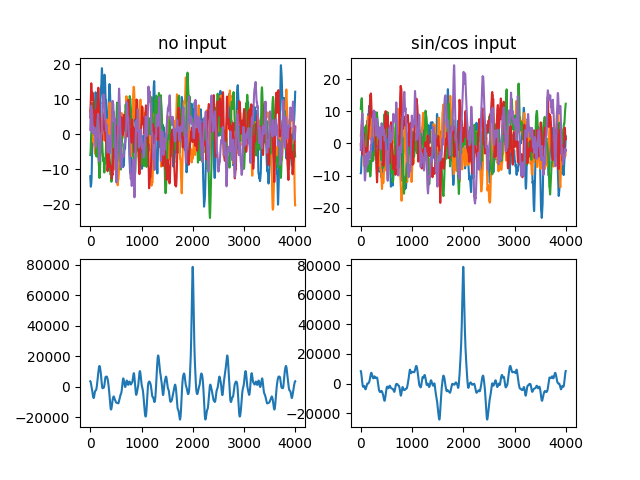

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=2)
random_5 = np.random.choice(1000, 5)
rsn_5 = r_store_noinput[1000:, random_5]
rsi_5 = r_store_input[1000:, random_5]

rsn_auto = np.mean(correlate(rsn_5, rsn_5, mode='full'), axis=1)
rsi_auto = np.mean(correlate(rsi_5, rsi_5, mode='full'), axis=1)
ax[0][0].set_title('no input')
ax[0][0].plot(rsn_5)
ax[0][1].set_title('sin/cos input')
ax[0][1].plot(rsi_5)
ax[1][0].plot(rsn_auto[2000:6000])
ax[1][1].plot(rsi_auto[2000:6000])


<font color=violet>1c. Now, let's look at how network dynamics change as a function of input amplitude. For your same network, plot the average autocorrelation across 50 random neurons in the model (again for 2000 lags) for a range of input magnitudes, until you see evidence of your input in your network's average autocorrelation. At what input magnitude does the network become entrained? Repeat using g=0.5 and g=5; what changes?</font>

Text(0.5, 1.0, 'looks like around 7x magnitude multiplier for input')

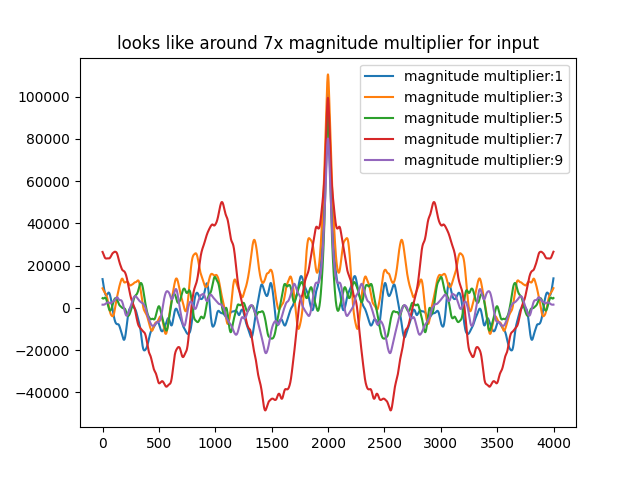

In [6]:
random_5 = np.random.choice(1000, 50)
rsi_list = []
magnitudes = np.arange(1,10,2)
for m in magnitudes:
    u=np.empty((2,5000))
    t = np.arange(5000)
    u[0,:] = m * np.sin(2*np.pi*t*.001)
    u[1,:] = m * np.cos(2*np.pi*t*.001)
    r_store_input= simulate_RNN(params, u)
    rsi_5 = r_store_input[1000:, random_5]
    rsi_auto = np.mean(correlate(rsi_5, rsi_5, mode='full'), axis=1)
    rsi_list.append(rsi_auto)
    
fig, ax= plt.subplots()
for idx, rsi in enumerate(rsi_list):
    ax.plot(rsi[2000:6000], label=f'magnitude multiplier:{magnitudes[idx]}')
ax.legend()
ax.set_title('looks like around 7x magnitude multiplier for input')

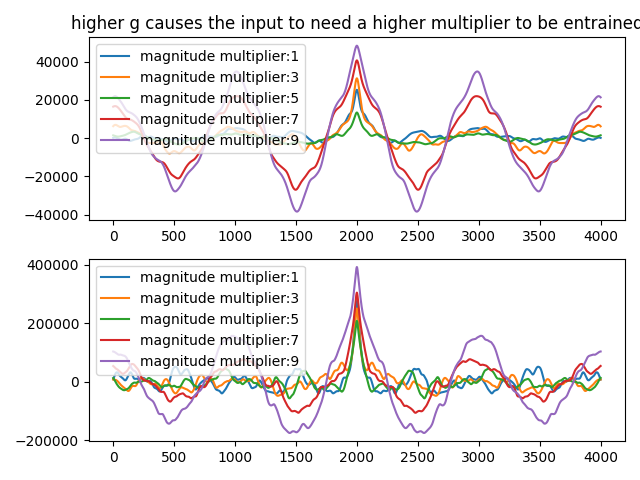

In [7]:
random_5 = np.random.choice(1000, 50)
rsi_list = []
magnitudes = np.arange(1,10,2)
params_smallg = {'N': 1000,      # number of neurons in the network
          'tau': 10,      # "membrane" time constant
          'dt': 1,        # simulation timestep
          'g': .5,         # gain on recurrent weights
          'n_inputs': 2,  # number of input channels
          'w': 0.1}       # variance of input weights
for m in magnitudes:
    u=np.empty((2,5000))
    t = np.arange(5000)
    u[0,:] = m * np.sin(2*np.pi*t*.001)
    u[1,:] = m * np.cos(2*np.pi*t*.001)
    r_store_input= simulate_RNN(params_smallg, u)
    rsi_5 = r_store_input[1000:, random_5]
    rsi_auto = np.mean(correlate(rsi_5, rsi_5, mode='full'), axis=1)
    rsi_list.append(rsi_auto)
    
fig, ax= plt.subplots(nrows=2)
for idx, rsi in enumerate(rsi_list):
    ax[0].plot(rsi[2000:6000], label=f'magnitude multiplier:{magnitudes[idx]}')
ax[0].legend()
rsi_list = []
params_largeg = {'N': 1000,      # number of neurons in the network
          'tau': 10,      # "membrane" time constant
          'dt': 1,        # simulation timestep
          'g': 5,         # gain on recurrent weights
          'n_inputs': 2,  # number of input channels
          'w': 0.1}       # variance of input weights
for m in magnitudes:
    u=np.empty((2,5000))
    t = np.arange(5000)
    u[0,:] = m * np.sin(2*np.pi*t*.001)
    u[1,:] = m * np.cos(2*np.pi*t*.001)
    r_store_input= simulate_RNN(params_largeg, u)
    rsi_5 = r_store_input[1000:, random_5]
    rsi_auto = np.mean(correlate(rsi_5, rsi_5, mode='full'), axis=1)
    rsi_list.append(rsi_auto)
    
for idx, rsi in enumerate(rsi_list):
    ax[1].plot(rsi[2000:6000], label=f'magnitude multiplier:{magnitudes[idx]}')
ax[1].legend()

ax[0].set_title('higher g causes the input to need a higher multiplier to be entrained')
fig.tight_layout()

### Problem 2. Training an RNN using Torch

In practice, you're likely going to find yourself using a package like PyTorch or Tensorflow for simulating or training RNNs. While we're not going to make you code up this training process from scratch, it's worth running the steps yourself to see what you can do with the results. We'll provide the model setup and training code to work from.

To start, let's define a task: we're going to drive our network with a pair of inputs:
\begin{equation}
u_1(t) = \sin(2\pi f_0 t + \phi) + \sin(2\pi\frac{f_0}{2} t + \phi_{d}) + \eta_1(t)\\
u_2(t) = \cos(2\pi f_0 t + \phi) + \cos(2\pi\frac{f_0}{2} t + \phi_{d}) + \eta_2(t)
\end{equation}

where $\phi$ and $\phi_d$ are randomly selected phase shifts and $\eta(t)$ is Gaussian noise. We want our network to predict the value of the first sin and cosine signals 5 timesteps into the future, and ignore the other terms.

\begin{equation}
f_1(t) = \sin(2\pi f_0 (t+5) + \phi)\\
f_2(t) = \cos(2\pi f_0 (t+5) + \phi)
\end{equation}

In [8]:
import numpy as np

def generate_sine_cosine_data(seq_length, num_sequences, freq=10, time_shift=5):
    X = []
    y = []
    for _ in range(num_sequences):
        t = np.linspace(0, seq_length, num=seq_length)

        # create our target signal- a sine wave and a cosine wave at the provided frequency, starting with random phase.
        phi = np.random.rand(1) * freq
        sine_target = np.sin(2 * np.pi * freq * t + phi)
        cosine_target = np.cos(2 * np.pi * freq * t + phi)
        sequence_target = np.stack((sine_target, cosine_target), axis=1)

        # create some distractor inputs to the network.
        phi = np.random.rand(1) * freq
        sine_distractor = np.sin(2 * np.pi * freq/2 * t + phi)
        cosine_distractor = np.cos(2 * np.pi * freq/2 * t + phi)
        noise_term = np.random.randn(sequence_target.shape[0],sequence_target.shape[1])

        sequence_input = np.stack((sine_target + sine_distractor, cosine_target + cosine_distractor), axis=1) + noise_term

        X.append(sequence_input[:-time_shift])
        y.append(sequence_target[time_shift:])
    return np.array(X), np.array(y)

seq_length = 300
num_sequences = 100
X, y = generate_sine_cosine_data(seq_length, num_sequences)

The following code will initialize our RNN model; be sure you run it and the cell above to set things up.

In [9]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

        # optional: if you uncomment the following lines you can modify the initial
        # weights of the model to see how it affects learning:
#         weights = self.rnn.state_dict()
#         weights['weight_hh_l0'] = torch.randn(hidden_size, hidden_size) * 1/np.sqrt(hidden_size)
#         self.rnn.load_state_dict(weights)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out

input_size = 2
hidden_size = 1000
output_size = 2
num_layers = 1

model = RNN(input_size, hidden_size, output_size, num_layers)


Torch initializes the RNN with no particular structure in its recurrent weight matrix. Let's take a look at its eigenvalues to confirm this.

<font color=violet>2a. We can access the recurrent weights from our model using the command `model.rnn.state_dict()['weight_hh_l0'].numpy()`. Using this, plot the real and imaginary components of the eigenvalues of the untrained weight matrix. Add a plot of a circle whose radius is the variance of the weights divided by $\sqrt(N)$, and confirm that this roughly encloses the eigenvalues.</font>

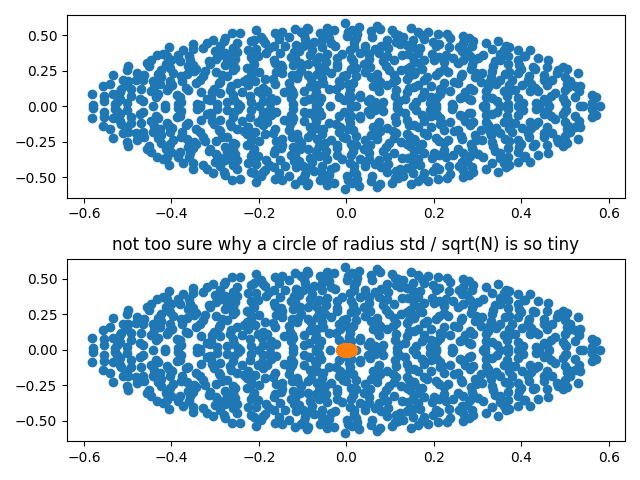

In [10]:
import copy
weights = model.rnn.state_dict()['weight_hh_l0'].numpy()
old_weights = copy.deepcopy(weights)
eigval, eigvec = np.linalg.eig(weights)
fig, ax = plt.subplots(nrows=2)
ax[0].scatter(np.real(eigval), np.imag(eigval))


r = np.std(eigval) / np.sqrt(hidden_size)
ax[1].scatter(np.real(eigval), np.imag(eigval))
a=np.arange(360)
px = r * np.cos(a)
py = r * np.sin(a)
ax[1].set_title('not too sure why a circle of radius std / sqrt(N) is so tiny')
ax[1].scatter(px, py)
fig.tight_layout()

Now, run the following code to train your model on the task! The loss will never go completely to zero (and you might not see a clean drop if you look just at every 5th entry), but the network should still get better at the task over time.

In [11]:
X_train = torch.tensor(X, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float32)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
batch_size = 64

for epoch in range(num_epochs):
    permutation = torch.randperm(X_train.size(0))
    for i in range(0, X_train.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_X, batch_y = X_train[indices], y_train[indices]

        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


/home/diya/anaconda3/envs/mp_opto/lib/python3.8/site-packages/torch/autograd/graph.py:744: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [5/100], Loss: 0.3792
Epoch [10/100], Loss: 0.3791
Epoch [15/100], Loss: 0.3042
Epoch [20/100], Loss: 0.3595
Epoch [25/100], Loss: 0.2651
Epoch [30/100], Loss: 0.3501
Epoch [35/100], Loss: 0.2650
Epoch [40/100], Loss: 0.3190
Epoch [45/100], Loss: 0.3247
Epoch [50/100], Loss: 0.2932
Epoch [55/100], Loss: 0.1508
Epoch [60/100], Loss: 0.4643
Epoch [65/100], Loss: 0.5281
Epoch [70/100], Loss: 0.3058
Epoch [75/100], Loss: 0.1762
Epoch [80/100], Loss: 0.3386
Epoch [85/100], Loss: 0.0864
Epoch [90/100], Loss: 0.0803
Epoch [95/100], Loss: 0.0549
Epoch [100/100], Loss: 0.0450


Finally, run this cell as a sanity check that training worked. Training an RNN is a bit stochastic, so if your network didn't converge on a solution, you can go back and run for more epochs, or run until the loss drops below a target value.

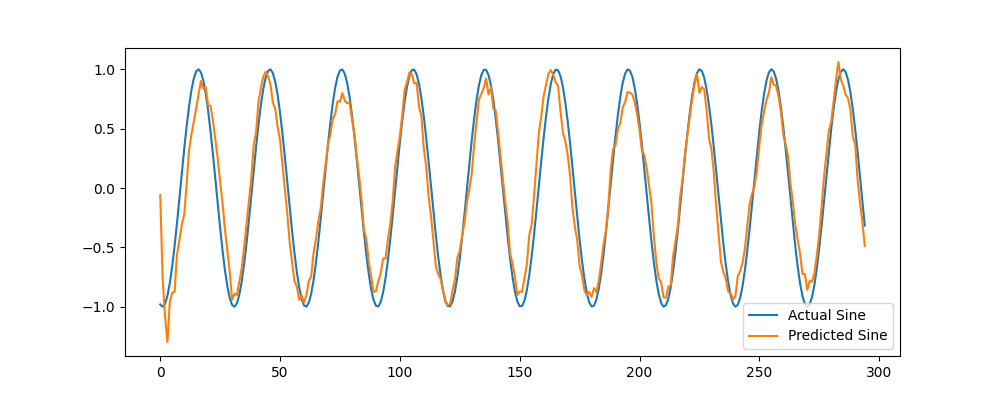

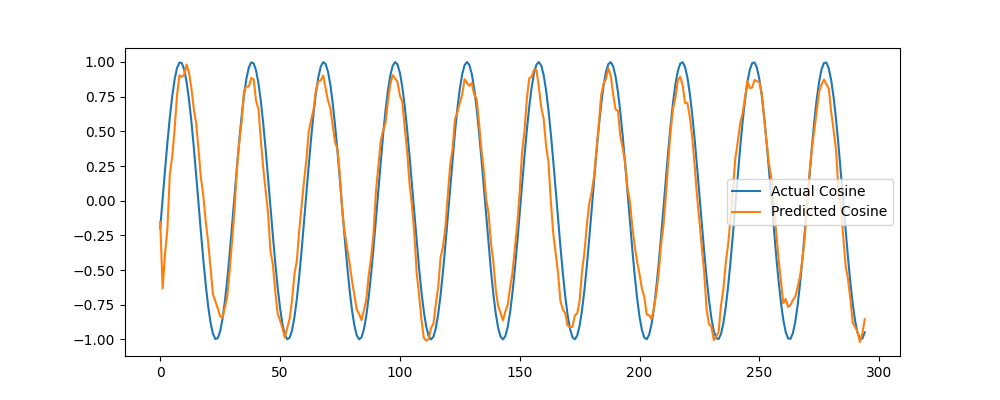

In [12]:
# Generate a test dataset
X_test, y_test = generate_sine_cosine_data(seq_length, 100)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

with torch.no_grad():
    predictions = model(X_test).numpy()

# Plot the predictions
trial = 10
plt.figure(figsize=(10, 4))
plt.plot(y_test[trial, :, 0], label='Actual Sine')
plt.plot(predictions[trial, :, 0], label='Predicted Sine')
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(y_test[trial, :, 1], label='Actual Cosine')
plt.plot(predictions[trial, :, 1], label='Predicted Cosine')
plt.legend()
plt.show()


<font color=violet>2b. What did training do to our recurrent weight matrix? To find out, plot the real and imaginary components of the eigenvalues of the trained weight matrix; on the same plot, add the eigenvalues of the original untrained model and the circle you computed previously. What has changed? Which of these changes are most relevant to the task this network is trying to perform?</font>

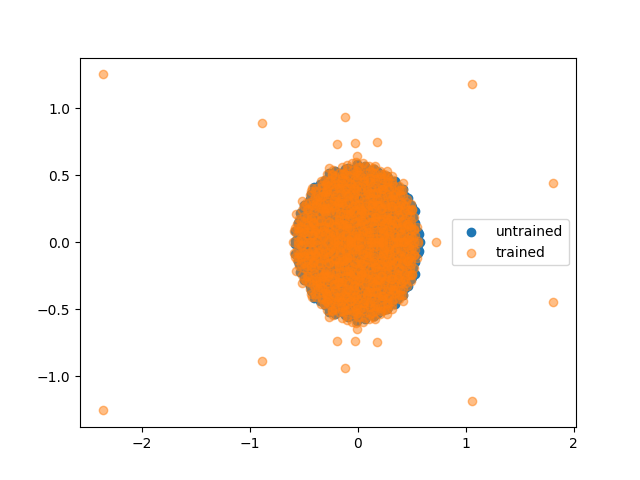

In [13]:
new_weights = model.rnn.state_dict()['weight_hh_l0'].numpy()
new_eigval, new_eigvec = np.linalg.eig(new_weights)
fig, ax = plt.subplots()
ax.scatter(np.real(eigval), np.imag(eigval), label='untrained')
ax.scatter(np.real(new_eigval), np.imag(new_eigval), alpha=0.5, label='trained')
ax.legend()



# eigenvalues are no longer uniformly distributed. The most relevant changes are now the large eigenvalues that are far out from the circle, these represent modes that can accomplish the task

<font color=violet>2c. Now, let's use our simulation code from problem 1 to look at the effect of this modified weight matrix on the network's dynamics. Modify your original `simulate_RNN` function to now take $J$ as an optional input, and pass it the weight matrix of the untrained or trained model. Drive both versions with 2d Gaussian white noise input and again look at the autocorrelation. Can you see a change in the dynamics of the trained network?</font>

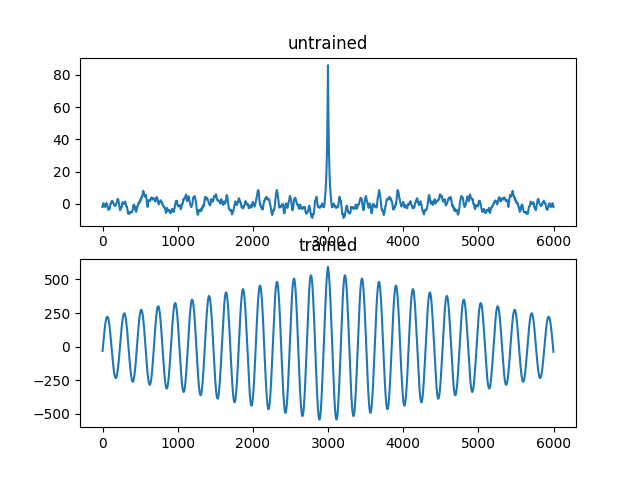

In [14]:
u_whitenoise = np.random.multivariate_normal(mean=[0,0], cov=np.identity(2), size=5000).T
r_untrained = simulate_RNN(params, u = u_whitenoise, T=5000, J = old_weights)
r_trained = simulate_RNN(params, u = u_whitenoise, T=5000, J = new_weights)
fig, ax = plt.subplots(nrows=2)
random_50 = np.random.choice(1000, 50)

ru = r_untrained[:, random_50]
ri = r_trained[:, random_50]
ru_auto = np.mean(correlate(ru, ru, mode='full'), axis=1)
ri_auto= np.mean(correlate(ri, ri, mode='full'), axis=1)
ax[0].set_title('untrained')
ax[0].plot(ru_auto[2000:8000])
ax[1].set_title('trained')
ax[1].plot(ri_auto[2000:8000])


# dynamics of trained model now show sin oscillations (built into weights of model)